In [485]:
import pandas as pd
import os
import json
import numpy as np
from statannot import add_stat_annotation
from scipy.stats import f_oneway 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Path to the directory containing the JSON files
path_to_json = os.path.join(os.getcwd(), "carbon_leakage")
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
def get_mitigation(global_state, members, total_regions):
    outputs = {}
    all_regions = range(0,total_regions)
    for member in all_regions:
        outputs[member] = {"values": [],
                           "control":member in members}
        for timestep in range(len(global_state["mitigation_rates_all_regions"]["value"])):
            mitigation_rate = global_state["mitigation_rates_all_regions"]["value"][timestep][member]
            outputs[member]["values"].append(mitigation_rate)

        outputs[member]["sum_mitigation"] = sum(outputs[member]["values"])
        outputs[member]["mean_mitigation"] = np.mean(outputs[member]["values"])
    return outputs

def get_emissions(global_state, members, total_regions):
    outputs = {}
    all_regions = range(0,total_regions)
    for member in all_regions:
        outputs[member] = {"values": [],
                           "control":member in members}
        for timestep in range(len(global_state["aux_m_all_regions"]["value"])):
            emissions_rate = global_state["aux_m_all_regions"]["value"][timestep][member][0]
            outputs[member]["values"].append(emissions_rate)

        outputs[member]["sum_emissions"] = sum(outputs[member]["values"])
        outputs[member]["mean_emissions"] = np.mean(outputs[member]["values"])
    return outputs

data = []
for idx, file in enumerate(json_files):
    with open(os.path.join(path_to_json, file), "r") as f:
        current_json = json.load(f)
    
    total_regions = len(current_json["global_state"]["mitigation_rates_all_regions"]["value"][0])
    club_members = current_json["club_members"]
    if "control" in file:
        condition = "control"
    else:
        condition = "treatment"

    data_ = current_json["global_state"]
    mit_data = get_mitigation(data_, club_members, total_regions)
    emissions_data = get_emissions(data_, club_members, total_regions)
    for member in mit_data.keys():
        mit_values = mit_data[member]
        emissions_values = emissions_data[member]
        data.append({
            "member": member,
            "club_member":mit_values["control"],
            "condition":condition,
            "sum_mitigation": mit_values["sum_mitigation"],
            "mean_mitigation": mit_values["mean_mitigation"],
            "mitigation_rates":mit_values["values"],
            "sum_emissions":emissions_values["sum_emissions"],
            "mean_emissions": emissions_values["mean_emissions"],
            "idx":idx,
            "club_members":club_members
        })
    


# Convert data to a pandas DataFrame
df = pd.DataFrame(data)

In [486]:
remove_cols = ["mitigation_rates", "club_members", "sum", "idx"]
df_sub = df[[col for col in
              df.columns if col not in remove_cols]]
df_ = df_sub[df_sub["club_member"]!=True]
df_.groupby(["member", "club_member", "condition"]).count()

sum_mitigation  mean_mitigation  sum_emissions  \
member club_member condition                                                   
0      False       control               218              218            218   
                   treatment             113              113            113   
1      False       control               218              218            218   
                   treatment             104              104            104   
2      False       control               218              218            218   
                   treatment             113              113            113   
3      False       control               218              218            218   
                   treatment             115              115            115   
4      False       control               218              218            218   
                   treatment             110              110            110   
5      False       control               218              218            218   
                   treatment             108              108            108   
6      False       control               218              218            218   
                   treatment             101              101            101   

                              mean_emissions  
member club_member condition                  
0      False       control               218  
                   treatment             113  
1      False       control               218  
                   treatment             104  
2      False       control               218  
                   treatment             113  
3      False       control               218  
                   treatment             115  
4      False       control               218  
                   treatment             110  
5      False       control               218  
                   treatment             108  
6      False       control               218  
                   treatment             101

In [487]:
remove_cols = ["mitigation_rates", "club_members", "sum", "idx"]
df_sub = df[[col for col in
              df.columns if col not in remove_cols]]
df_mit = df_sub[["member", "club_member", "condition", "mean_mitigation"]]
df_mit=df_mit[df_mit["club_member"]!=True]
dfg_mit = df_mit.groupby(["member", "club_member", "condition"]).mean().reset_index()
dfg_mit

,member,club_member,condition,mean_mitigation
0,0,False,control,0.347330
1,0,False,treatment,0.346375
2,1,False,control,0.343446
3,1,False,treatment,0.332894
4,2,False,control,0.427528
5,2,False,treatment,0.425887
6,3,False,control,0.381270
7,3,False,treatment,0.380184
8,4,False,control,0.375615
9,4,False,treatment,0.405015


In [488]:
def split_groups_mitigation_by_id(df, id):
    df = df[df["member"]==id]
    control = df[df["condition"]=="control"]
    control = control.rename(columns={"mean_mitigation":f"m_c_{id}"})
    treatment = df[df["condition"]=="treatment"]
    treatment = treatment.rename(columns={"mean_mitigation":f"m_t_{id}"})

    length = min(len(treatment), len(control))
    treatment = treatment.head(length)[f"m_t_{id}"].reset_index()
    control = control.head(length)[f"m_c_{id}"].reset_index()
    merged = pd.concat([control, treatment],axis=1)
    return merged
df_mit_split = split_groups_mitigation_by_id(df_mit,0)
df_mit_split


,index,m_c_0,index,m_t_0
0,7,0.223914,49,0.381057
1,14,0.342962,105,0.300104
2,21,0.366771,112,0.319152
3,28,0.300104,182,0.347724
4,35,0.404866,189,0.385819
...,...,...,...,...
108,1526,0.409628,2877,0.347724
109,1547,0.333438,2884,0.433438
110,1561,0.295343,2912,0.419152
111,1575,0.385819,3017,0.419152


In [489]:
members = list(set(df["member"].values))
all_mitigation_data = []
for member in members:
    member_data = split_groups_mitigation_by_id(df_mit, member)
    member_data = member_data[[f"m_c_{member}",f"m_t_{member}"]]
    all_mitigation_data.append(member_data)
length = min([len(dat) for dat in all_mitigation_data])
combined_mitigation_data = pd.concat([dat.head(length) for dat in all_mitigation_data], axis=1).dropna(axis=0)
combined_mitigation_data

,m_c_0,m_t_0,m_c_1,m_t_1,m_c_2,m_t_2,m_c_3,m_t_3,m_c_4,m_t_4,m_c_5,m_t_5,m_c_6,m_t_6
0,0.223914,0.381057,0.400065,0.252446,0.347843,0.500224,0.462047,0.366809,0.366790,0.438218,0.376676,0.424295,0.314737,0.309975
1,0.342962,0.300104,0.309588,0.185779,0.481176,0.457366,0.328714,0.395381,0.323933,0.462028,0.386199,0.357628,0.333785,0.319499
2,0.366771,0.319152,0.361969,0.342922,0.452605,0.343081,0.357285,0.352523,0.414409,0.409647,0.319533,0.452866,0.324261,0.276642
3,0.300104,0.347724,0.319112,0.366731,0.395462,0.333557,0.395381,0.395381,0.290599,0.523933,0.362390,0.333818,0.376642,0.281404
4,0.404866,0.385819,0.390541,0.290541,0.438319,0.457366,0.414428,0.457285,0.452504,0.314409,0.448104,0.357628,0.324261,0.295690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.333438,0.357247,0.395303,0.247684,0.371652,0.528795,0.438238,0.457285,0.290599,0.462028,0.362390,0.538580,0.209975,0.295690
97,0.338200,0.395343,0.295303,0.228636,0.362128,0.376414,0.504904,0.414428,0.366790,0.319171,0.429057,0.390961,0.295690,0.229023
98,0.333438,0.328676,0.371493,0.333398,0.485938,0.376414,0.423952,0.381095,0.338218,0.409647,0.386199,0.462390,0.362356,0.305213
99,0.333438,0.347724,0.323874,0.371493,0.519271,0.371652,0.381095,0.390619,0.442980,0.462028,0.362390,0.433818,0.324261,0.229023


/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

m_c_1 v.s. m_t_1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.520e+03
m_c_5 v.s. m_t_5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.513e-01 U_stat=4.457e+03
m_c_2 v.s. m_t_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.190e+03
m_c_3 v.s. m_t_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.490e+03
m_c_4 v.s. m_t_4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.203e-04 U_stat=3.407e+03
m_c_0 v.s. m_t_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.255e+03
m_c_6 v.s. m_t_6: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.318e-02 U_stat=6.164e+03


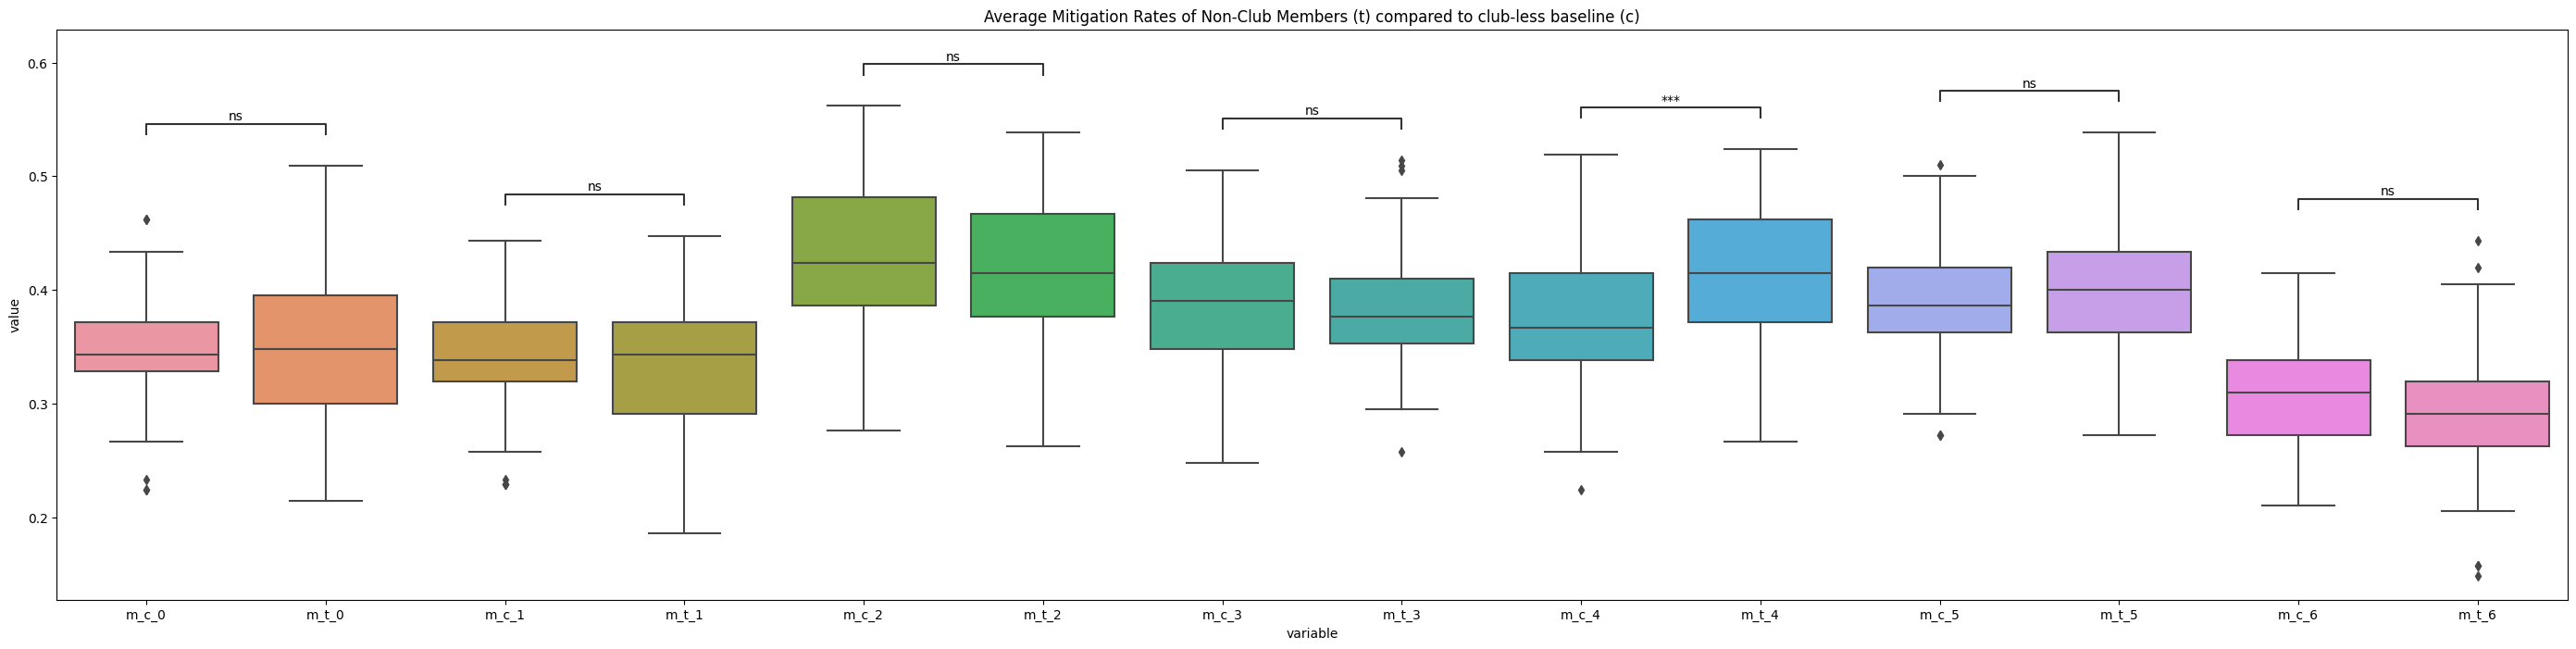

In [490]:
col_order = [col for col in combined_mitigation_data.columns if "m_" in col]
col_order.sort(key = lambda x: int(x.split("_")[-1]))

x="variable"
y="value"
plt.figure(figsize=(35,8))

ax = sns.boxplot(x="variable", y="value", order = col_order, data=pd.melt(combined_mitigation_data))
box_pairs = []
for member in members:
    box_pairs.append((f"m_c_{member}",f"m_t_{member}"))
fset = set(frozenset(x) for x in box_pairs)
box_pairs = [tuple(x) for x in fset]

ax, test_results = add_stat_annotation(ax, data=pd.melt(combined_mitigation_data), x=x, y=y,order=col_order,
                            box_pairs = box_pairs, test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.title("Average Mitigation Rates of Non-Club Members (t) compared to club-less baseline (c)")
plt.show()

In [491]:
df_emissions = df_sub[["member", "club_member", "condition", "mean_emissions"]]
#df_emissions = df_emissions.groupby(["member", "club_member", "condition"]).mean().reset_index()
df_emissions = df_emissions[df_emissions["club_member"]!=True]

In [492]:
def split_groups_emissions_by_id(df, id):
    df = df[df["member"]==id]
    control = df[df["condition"]=="control"]
    control = control.rename(columns={"mean_emissions":f"e_c_{id}"})
    treatment = df[df["condition"]=="treatment"]
    treatment = treatment.rename(columns={"mean_emissions":f"e_t_{id}"})
    length = min(len(treatment), len(control))
    treatment = treatment.head(length)[f"e_t_{id}"].reset_index()
    control = control.head(length)[f"e_c_{id}"].reset_index()
    merged = pd.concat([control, treatment],axis=1)
    return merged


In [493]:
members = list(set(df["member"].values))
all_emissions_data = []
for member in members:
    member_data = split_groups_emissions_by_id(df_emissions, member)
    member_data = member_data[[f"e_c_{member}",f"e_t_{member}"]]
    all_emissions_data.append(member_data)
combined_emissions_data = pd.concat(all_emissions_data, axis=1).dropna(axis=0)
    

/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/pwozny/opt/anaconda3/envs/simple/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

e_c_2 v.s. e_t_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.270e+03
e_c_6 v.s. e_t_6: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.597e-02 U_stat=3.971e+03
e_c_3 v.s. e_t_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.048e+03
e_c_1 v.s. e_t_1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.959e+03
e_c_0 v.s. e_t_0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.431e+03
e_c_5 v.s. e_t_5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.405e-01 U_stat=5.835e+03
e_c_4 v.s. e_t_4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.158e-04 U_stat=6.832e+03


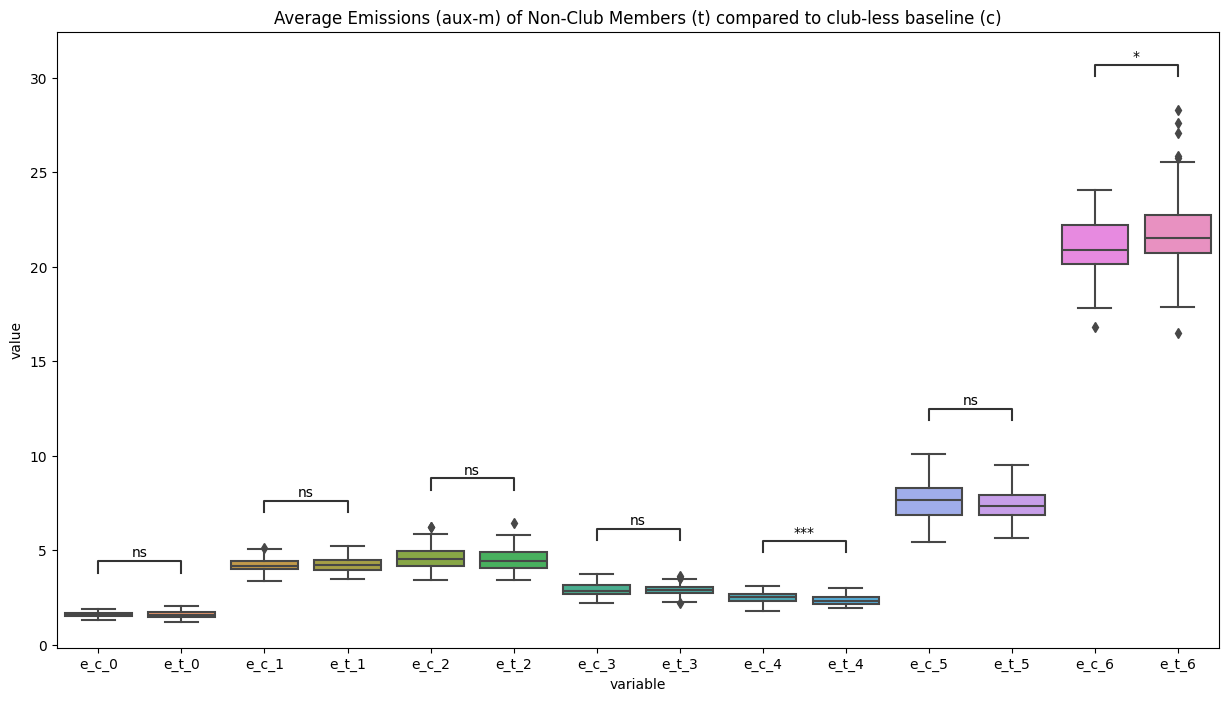

In [494]:
col_order = [col for col in combined_emissions_data.columns if "e_" in col]
col_order.sort(key = lambda x: int(x.split("_")[-1]))

x="variable"
y="value"
plt.figure(figsize=(15,8))

ax = sns.boxplot(x="variable", y="value", order = col_order, data=pd.melt(combined_emissions_data))
box_pairs = []
for member in members:
    box_pairs.append((f"e_c_{member}",f"e_t_{member}"))
fset = set(frozenset(x) for x in box_pairs)
box_pairs = [tuple(x) for x in fset]

ax, test_results = add_stat_annotation(ax, data=pd.melt(combined_emissions_data), x=x, y=y,order=col_order,
                            box_pairs = box_pairs, test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.title("Average Emissions (aux-m) of Non-Club Members (t) compared to club-less baseline (c)")
plt.show()